#**Ten Categories**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

In [ ]:
import os
import numpy as np
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from  torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from google.colab import files
import pickle

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt


# Other constants
model_save_name = 'resnet_10_categories_model.pth'
statistic_save_name = 'resnet_10_categories_statistic.pkl'
statistic_path = F"/content/drive/My Drive/comp6721-project/{statistic_save_name}"
model_path = F"/content/drive/My Drive/comp6721-project/{model_save_name}" 

ROOT_PATH = '/content/drive/MyDrive/comp6721-project/datasets/dataset-10/'
training_path = f'{ROOT_PATH}/train'
validation_path = f'{ROOT_PATH}/val'
evaluation_path = f'{ROOT_PATH}/test'

# Model training constants
batch_size = 32
num_epochs = 15

# Loss function & optimizer constants
lr = 0.0001

# Image constants
image_size = 256
mean = [0.554, 0.450, 0.343]
std = [0.231, 0.241, 0.241]
num_classes = 10

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


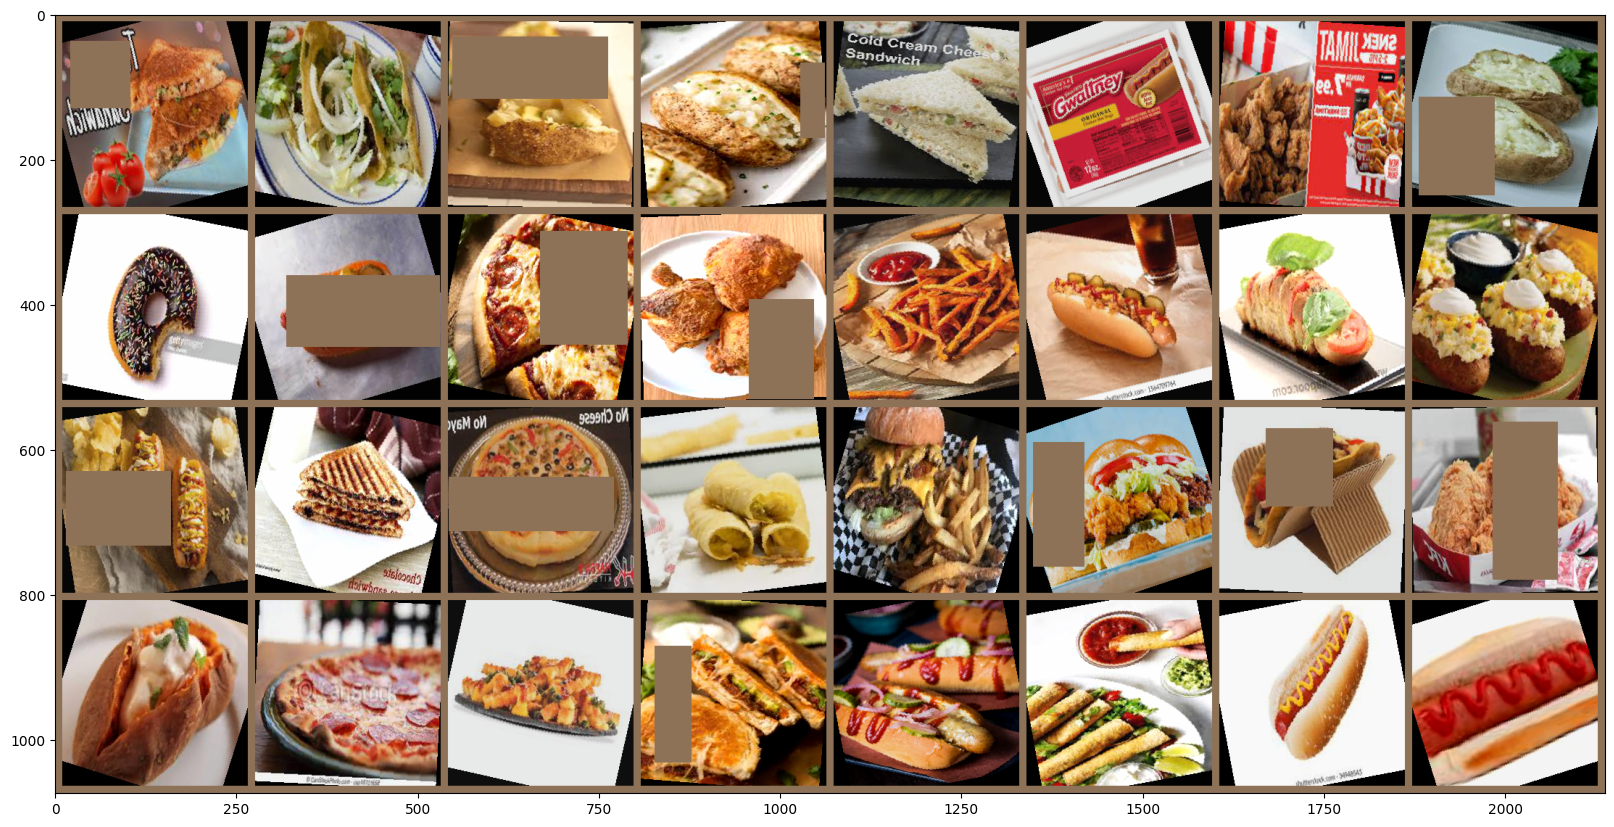

In [ ]:
# Transform
main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    transforms.RandomErasing()
])

# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=False)
in_features = int(model.fc.in_features)
model.fc = nn.Linear(in_features, num_classes, device)
model = model.to(device)

# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Dataset
train_dataset = datasets.ImageFolder(training_path, transform=aug_transform)
evaluation_dataset = datasets.ImageFolder(evaluation_path, transform=main_transform)
validation_dataset = datasets.ImageFolder(validation_path, transform=main_transform)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)
evaluation_dataloader = DataLoader(evaluation_dataset, batch_size = batch_size, shuffle=False, num_workers=2)
validation_dataloader = DataLoader(validation_dataset, batch_size = batch_size, shuffle=False, num_workers=2)

# Image samples
images, targets = next(iter(train_dataloader))
grid_images = torchvision.utils.make_grid(images, nrow=8, padding=10)

def imshow(images, mean, std):
        np_image = np.array(images).transpose((1,2,0))
        unnorm_image = np_image * std + mean
        plt.figure(figsize=(20,20))
        plt.imshow(unnorm_image)
        
imshow(grid_images, mean, std)

## Training

In [ ]:
# Training
%%time

accuracy = []
valid_accuracy = []
step_accuracy_total = []
step_accuracy_validation_total = []
step_loss_total = []
loss = []
total_steps = len(train_dataloader)


for epoch in range(num_epochs):
    step_acc = []
    step_loss = []
    for i , (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        #train model
        outputs = model(inputs)
        
        #criterion
        loss_v = criterion(outputs, labels)
        
        #backward
        optimizer.zero_grad()
        loss_v.backward()
        
        #update parameters
        optimizer.step()
        
        #train accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        step_acc.append((correct / total) * 100)
        step_loss.append(loss_v.item())
        if (i + 1) % 30 == 0:
            step_accuracy_total.append((correct / total) * 100)
            step_loss_total.append(loss_v.item())
            correct_v = 0
            total_v = 0
            for dataVal in validation_dataloader:
                images_v, labels_v = dataVal[0].to(device), dataVal[1].to(device)
                outputs = model(images_v)
                _, predicted = torch.max(outputs.data, 1)
                correct_v += (predicted == labels_v).sum().item()
                total_v += labels_v.size(0) 
            step_accuracy_validation_total.append((correct_v / total_v) * 100)
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_steps, loss_v.item(),(correct / total) * 100,(correct_v / total_v) * 100))     
      
    correct_v = 0
    total_v = 0
    for dataVal in validation_dataloader:
        images_v, labels_v = dataVal[0].to(device), dataVal[1].to(device)
        outputs = model(images_v)
        _, predicted = torch.max(outputs.data, 1)
        correct_v += (predicted == labels_v).sum().item()
        total_v += labels_v.size(0)        
    accuracy.append(sum(step_acc)/len(step_acc))
    valid_accuracy.append((correct_v / total_v) * 100)
    loss.append(sum(step_loss)/len(step_loss))



Epoch [1/15], Step [30/469], Loss: 2.1180, Accuracy: 25.00%, Validation Accuracy: 10.71%
Epoch [1/15], Step [60/469], Loss: 2.1183, Accuracy: 21.88%, Validation Accuracy: 9.83%


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/15], Step [90/469], Loss: 2.0568, Accuracy: 21.88%, Validation Accuracy: 9.94%
Epoch [1/15], Step [120/469], Loss: 1.8157, Accuracy: 28.12%, Validation Accuracy: 10.31%
Epoch [1/15], Step [150/469], Loss: 2.2265, Accuracy: 18.75%, Validation Accuracy: 11.31%
Epoch [1/15], Step [180/469], Loss: 1.4221, Accuracy: 53.12%, Validation Accuracy: 11.60%


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/15], Step [210/469], Loss: 1.6265, Accuracy: 40.62%, Validation Accuracy: 11.54%
Epoch [1/15], Step [240/469], Loss: 1.6154, Accuracy: 43.75%, Validation Accuracy: 12.46%
Epoch [1/15], Step [270/469], Loss: 1.5499, Accuracy: 34.38%, Validation Accuracy: 11.51%
Epoch [1/15], Step [300/469], Loss: 1.8859, Accuracy: 37.50%, Validation Accuracy: 11.60%
Epoch [1/15], Step [330/469], Loss: 1.7938, Accuracy: 46.88%, Validation Accuracy: 13.29%
Epoch [1/15], Step [360/469], Loss: 1.5999, Accuracy: 50.00%, Validation Accuracy: 13.14%
Epoch [1/15], Step [390/469], Loss: 1.8598, Accuracy: 46.88%, Validation Accuracy: 12.86%
Epoch [1/15], Step [420/469], Loss: 1.5763, Accuracy: 50.00%, Validation Accuracy: 12.71%
Epoch [1/15], Step [450/469], Loss: 1.7148, Accuracy: 37.50%, Validation Accuracy: 14.37%
Epoch [2/15], Step [30/469], Loss: 1.6237, Accuracy: 50.00%, Validation Accuracy: 12.86%
Epoch [2/15], Step [60/469], Loss: 1.3038, Accuracy: 59.38%, Validation Accuracy: 12.97%
Epoch [2/15]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [2/15], Step [120/469], Loss: 1.2335, Accuracy: 59.38%, Validation Accuracy: 13.71%
Epoch [2/15], Step [150/469], Loss: 1.6875, Accuracy: 31.25%, Validation Accuracy: 12.94%
Epoch [2/15], Step [180/469], Loss: 1.6238, Accuracy: 50.00%, Validation Accuracy: 13.91%
Epoch [2/15], Step [210/469], Loss: 1.5150, Accuracy: 53.12%, Validation Accuracy: 13.80%
Epoch [2/15], Step [240/469], Loss: 1.5205, Accuracy: 46.88%, Validation Accuracy: 13.69%
Epoch [2/15], Step [270/469], Loss: 1.2658, Accuracy: 59.38%, Validation Accuracy: 14.69%
Epoch [2/15], Step [300/469], Loss: 1.4262, Accuracy: 53.12%, Validation Accuracy: 14.17%
Epoch [2/15], Step [330/469], Loss: 1.6300, Accuracy: 59.38%, Validation Accuracy: 13.60%


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [2/15], Step [360/469], Loss: 1.5488, Accuracy: 46.88%, Validation Accuracy: 14.14%
Epoch [2/15], Step [390/469], Loss: 1.7459, Accuracy: 40.62%, Validation Accuracy: 13.54%
Epoch [2/15], Step [420/469], Loss: 1.5342, Accuracy: 40.62%, Validation Accuracy: 13.89%
Epoch [2/15], Step [450/469], Loss: 1.1406, Accuracy: 62.50%, Validation Accuracy: 14.51%
Epoch [3/15], Step [30/469], Loss: 1.1016, Accuracy: 65.62%, Validation Accuracy: 14.00%
Epoch [3/15], Step [60/469], Loss: 1.9263, Accuracy: 34.38%, Validation Accuracy: 14.97%


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [3/15], Step [90/469], Loss: 1.5142, Accuracy: 56.25%, Validation Accuracy: 14.51%
Epoch [3/15], Step [120/469], Loss: 1.2696, Accuracy: 62.50%, Validation Accuracy: 14.49%
Epoch [3/15], Step [150/469], Loss: 0.9817, Accuracy: 65.62%, Validation Accuracy: 14.86%
Epoch [3/15], Step [180/469], Loss: 1.2791, Accuracy: 59.38%, Validation Accuracy: 15.37%


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [3/15], Step [210/469], Loss: 1.2730, Accuracy: 62.50%, Validation Accuracy: 15.09%
Epoch [3/15], Step [240/469], Loss: 1.0106, Accuracy: 62.50%, Validation Accuracy: 14.06%
Epoch [3/15], Step [270/469], Loss: 1.2031, Accuracy: 65.62%, Validation Accuracy: 15.09%
Epoch [3/15], Step [300/469], Loss: 1.0160, Accuracy: 59.38%, Validation Accuracy: 15.29%
Epoch [3/15], Step [330/469], Loss: 1.3961, Accuracy: 56.25%, Validation Accuracy: 13.74%
Epoch [3/15], Step [360/469], Loss: 1.3227, Accuracy: 53.12%, Validation Accuracy: 14.03%
Epoch [3/15], Step [390/469], Loss: 1.3124, Accuracy: 59.38%, Validation Accuracy: 14.86%
Epoch [3/15], Step [420/469], Loss: 1.1973, Accuracy: 59.38%, Validation Accuracy: 15.57%
Epoch [3/15], Step [450/469], Loss: 1.2269, Accuracy: 59.38%, Validation Accuracy: 15.43%


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [4/15], Step [30/469], Loss: 1.0982, Accuracy: 53.12%, Validation Accuracy: 15.23%
Epoch [4/15], Step [60/469], Loss: 0.8207, Accuracy: 68.75%, Validation Accuracy: 15.29%
Epoch [4/15], Step [90/469], Loss: 0.9857, Accuracy: 68.75%, Validation Accuracy: 15.11%
Epoch [4/15], Step [120/469], Loss: 0.6497, Accuracy: 84.38%, Validation Accuracy: 14.43%
Epoch [4/15], Step [150/469], Loss: 1.2449, Accuracy: 62.50%, Validation Accuracy: 15.46%
Epoch [4/15], Step [180/469], Loss: 1.4723, Accuracy: 46.88%, Validation Accuracy: 15.31%
Epoch [4/15], Step [210/469], Loss: 1.4269, Accuracy: 59.38%, Validation Accuracy: 14.00%
Epoch [4/15], Step [240/469], Loss: 1.1073, Accuracy: 56.25%, Validation Accuracy: 15.29%
Epoch [4/15], Step [270/469], Loss: 0.9280, Accuracy: 71.88%, Validation Accuracy: 14.40%
Epoch [4/15], Step [300/469], Loss: 1.5323, Accuracy: 40.62%, Validation Accuracy: 15.54%
Epoch [4/15], Step [330/469], Loss: 1.3566, Accuracy: 59.38%, Validation Accuracy: 15.26%
Epoch [4/15],

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [4/15], Step [450/469], Loss: 0.8784, Accuracy: 68.75%, Validation Accuracy: 15.46%
Epoch [5/15], Step [30/469], Loss: 1.3014, Accuracy: 59.38%, Validation Accuracy: 15.54%
Epoch [5/15], Step [60/469], Loss: 1.2811, Accuracy: 50.00%, Validation Accuracy: 15.80%
Epoch [5/15], Step [90/469], Loss: 1.0705, Accuracy: 59.38%, Validation Accuracy: 15.66%
Epoch [5/15], Step [120/469], Loss: 0.8126, Accuracy: 71.88%, Validation Accuracy: 15.31%
Epoch [5/15], Step [150/469], Loss: 0.9339, Accuracy: 81.25%, Validation Accuracy: 16.34%
Epoch [5/15], Step [180/469], Loss: 1.4280, Accuracy: 65.62%, Validation Accuracy: 14.86%
Epoch [5/15], Step [210/469], Loss: 1.0688, Accuracy: 59.38%, Validation Accuracy: 15.46%
Epoch [5/15], Step [240/469], Loss: 1.1755, Accuracy: 53.12%, Validation Accuracy: 15.94%


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [5/15], Step [270/469], Loss: 1.1523, Accuracy: 56.25%, Validation Accuracy: 15.74%
Epoch [5/15], Step [300/469], Loss: 1.0734, Accuracy: 68.75%, Validation Accuracy: 15.43%
Epoch [5/15], Step [330/469], Loss: 1.2084, Accuracy: 59.38%, Validation Accuracy: 15.80%
Epoch [5/15], Step [360/469], Loss: 0.8059, Accuracy: 81.25%, Validation Accuracy: 15.57%
Epoch [5/15], Step [390/469], Loss: 1.1370, Accuracy: 59.38%, Validation Accuracy: 15.86%
Epoch [5/15], Step [420/469], Loss: 0.9622, Accuracy: 68.75%, Validation Accuracy: 15.23%
Epoch [5/15], Step [450/469], Loss: 1.0797, Accuracy: 53.12%, Validation Accuracy: 15.49%


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [6/15], Step [30/469], Loss: 0.8882, Accuracy: 68.75%, Validation Accuracy: 15.46%
Epoch [6/15], Step [60/469], Loss: 0.9575, Accuracy: 65.62%, Validation Accuracy: 15.74%
Epoch [6/15], Step [90/469], Loss: 0.7079, Accuracy: 78.12%, Validation Accuracy: 15.94%
Epoch [6/15], Step [120/469], Loss: 1.1787, Accuracy: 62.50%, Validation Accuracy: 15.17%
Epoch [6/15], Step [150/469], Loss: 1.1266, Accuracy: 59.38%, Validation Accuracy: 16.03%
Epoch [6/15], Step [180/469], Loss: 0.9613, Accuracy: 71.88%, Validation Accuracy: 16.49%
Epoch [6/15], Step [210/469], Loss: 1.1178, Accuracy: 56.25%, Validation Accuracy: 15.86%
Epoch [6/15], Step [240/469], Loss: 1.1618, Accuracy: 62.50%, Validation Accuracy: 16.97%
Epoch [6/15], Step [270/469], Loss: 1.0369, Accuracy: 68.75%, Validation Accuracy: 16.69%
Epoch [6/15], Step [300/469], Loss: 1.2745, Accuracy: 56.25%, Validation Accuracy: 16.00%
Epoch [6/15], Step [330/469], Loss: 1.0189, Accuracy: 59.38%, Validation Accuracy: 15.54%
Epoch [6/15],

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [7/15], Step [240/469], Loss: 0.6534, Accuracy: 81.25%, Validation Accuracy: 16.09%
Epoch [7/15], Step [270/469], Loss: 0.8929, Accuracy: 65.62%, Validation Accuracy: 16.77%
Epoch [7/15], Step [300/469], Loss: 1.2760, Accuracy: 50.00%, Validation Accuracy: 16.40%
Epoch [7/15], Step [330/469], Loss: 0.9117, Accuracy: 78.12%, Validation Accuracy: 16.63%
Epoch [7/15], Step [360/469], Loss: 0.9631, Accuracy: 71.88%, Validation Accuracy: 16.29%


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [7/15], Step [390/469], Loss: 1.2067, Accuracy: 65.62%, Validation Accuracy: 16.20%
Epoch [7/15], Step [420/469], Loss: 1.0330, Accuracy: 65.62%, Validation Accuracy: 16.14%
Epoch [7/15], Step [450/469], Loss: 0.8745, Accuracy: 78.12%, Validation Accuracy: 16.40%
Epoch [8/15], Step [30/469], Loss: 0.8484, Accuracy: 75.00%, Validation Accuracy: 16.20%
Epoch [8/15], Step [60/469], Loss: 0.9391, Accuracy: 59.38%, Validation Accuracy: 16.97%
Epoch [8/15], Step [90/469], Loss: 1.3313, Accuracy: 56.25%, Validation Accuracy: 17.40%
Epoch [8/15], Step [120/469], Loss: 1.2115, Accuracy: 56.25%, Validation Accuracy: 16.31%


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [8/15], Step [150/469], Loss: 0.7260, Accuracy: 84.38%, Validation Accuracy: 17.49%
Epoch [8/15], Step [180/469], Loss: 0.9350, Accuracy: 71.88%, Validation Accuracy: 16.57%


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [8/15], Step [210/469], Loss: 0.7619, Accuracy: 75.00%, Validation Accuracy: 16.17%
Epoch [8/15], Step [240/469], Loss: 0.9680, Accuracy: 68.75%, Validation Accuracy: 16.63%
Epoch [8/15], Step [270/469], Loss: 0.8905, Accuracy: 75.00%, Validation Accuracy: 16.37%
Epoch [8/15], Step [300/469], Loss: 0.8133, Accuracy: 78.12%, Validation Accuracy: 17.03%
Epoch [8/15], Step [330/469], Loss: 0.6755, Accuracy: 81.25%, Validation Accuracy: 17.74%
Epoch [8/15], Step [360/469], Loss: 1.2659, Accuracy: 56.25%, Validation Accuracy: 16.57%
Epoch [8/15], Step [390/469], Loss: 1.0856, Accuracy: 59.38%, Validation Accuracy: 16.31%
Epoch [8/15], Step [420/469], Loss: 0.8000, Accuracy: 68.75%, Validation Accuracy: 16.57%
Epoch [8/15], Step [450/469], Loss: 0.9945, Accuracy: 75.00%, Validation Accuracy: 16.00%
Epoch [9/15], Step [30/469], Loss: 1.3224, Accuracy: 46.88%, Validation Accuracy: 16.66%
Epoch [9/15], Step [60/469], Loss: 0.6423, Accuracy: 81.25%, Validation Accuracy: 16.71%
Epoch [9/15]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [9/15], Step [330/469], Loss: 0.8915, Accuracy: 71.88%, Validation Accuracy: 16.66%
Epoch [9/15], Step [360/469], Loss: 0.5839, Accuracy: 78.12%, Validation Accuracy: 17.14%
Epoch [9/15], Step [390/469], Loss: 0.8403, Accuracy: 75.00%, Validation Accuracy: 17.69%
Epoch [9/15], Step [420/469], Loss: 1.0067, Accuracy: 71.88%, Validation Accuracy: 16.17%


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [9/15], Step [450/469], Loss: 0.9991, Accuracy: 68.75%, Validation Accuracy: 16.71%
Epoch [10/15], Step [30/469], Loss: 0.8856, Accuracy: 75.00%, Validation Accuracy: 17.11%


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [10/15], Step [60/469], Loss: 1.0152, Accuracy: 68.75%, Validation Accuracy: 16.91%
Epoch [10/15], Step [90/469], Loss: 0.7892, Accuracy: 75.00%, Validation Accuracy: 17.09%


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [10/15], Step [120/469], Loss: 0.9771, Accuracy: 71.88%, Validation Accuracy: 16.54%
Epoch [10/15], Step [150/469], Loss: 0.7148, Accuracy: 78.12%, Validation Accuracy: 16.31%
Epoch [10/15], Step [180/469], Loss: 0.6953, Accuracy: 81.25%, Validation Accuracy: 17.69%
Epoch [10/15], Step [210/469], Loss: 0.9765, Accuracy: 71.88%, Validation Accuracy: 15.26%
Epoch [10/15], Step [240/469], Loss: 0.6929, Accuracy: 75.00%, Validation Accuracy: 16.74%
Epoch [10/15], Step [270/469], Loss: 0.8159, Accuracy: 62.50%, Validation Accuracy: 16.57%
Epoch [10/15], Step [300/469], Loss: 0.6401, Accuracy: 81.25%, Validation Accuracy: 17.46%
Epoch [10/15], Step [330/469], Loss: 1.1702, Accuracy: 56.25%, Validation Accuracy: 16.86%
Epoch [10/15], Step [360/469], Loss: 0.7612, Accuracy: 71.88%, Validation Accuracy: 16.40%
Epoch [10/15], Step [390/469], Loss: 1.1562, Accuracy: 71.88%, Validation Accuracy: 17.03%
Epoch [10/15], Step [420/469], Loss: 0.8079, Accuracy: 68.75%, Validation Accuracy: 17.74%

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [11/15], Step [120/469], Loss: 0.3211, Accuracy: 96.88%, Validation Accuracy: 17.29%
Epoch [11/15], Step [150/469], Loss: 0.9074, Accuracy: 65.62%, Validation Accuracy: 17.14%
Epoch [11/15], Step [180/469], Loss: 0.9541, Accuracy: 65.62%, Validation Accuracy: 15.94%
Epoch [11/15], Step [210/469], Loss: 0.4743, Accuracy: 87.50%, Validation Accuracy: 17.26%
Epoch [11/15], Step [240/469], Loss: 1.0787, Accuracy: 65.62%, Validation Accuracy: 17.00%
Epoch [11/15], Step [270/469], Loss: 0.7982, Accuracy: 81.25%, Validation Accuracy: 17.26%
Epoch [11/15], Step [300/469], Loss: 0.9306, Accuracy: 71.88%, Validation Accuracy: 16.89%


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [11/15], Step [330/469], Loss: 0.5938, Accuracy: 81.25%, Validation Accuracy: 16.91%
Epoch [11/15], Step [360/469], Loss: 0.9667, Accuracy: 71.88%, Validation Accuracy: 17.29%
Epoch [11/15], Step [390/469], Loss: 0.6539, Accuracy: 75.00%, Validation Accuracy: 16.03%
Epoch [11/15], Step [420/469], Loss: 0.9312, Accuracy: 62.50%, Validation Accuracy: 17.11%
Epoch [11/15], Step [450/469], Loss: 0.6996, Accuracy: 81.25%, Validation Accuracy: 17.63%
Epoch [12/15], Step [30/469], Loss: 0.8697, Accuracy: 78.12%, Validation Accuracy: 17.23%
Epoch [12/15], Step [60/469], Loss: 0.5322, Accuracy: 87.50%, Validation Accuracy: 17.03%
Epoch [12/15], Step [90/469], Loss: 0.6385, Accuracy: 81.25%, Validation Accuracy: 17.34%
Epoch [12/15], Step [120/469], Loss: 0.7263, Accuracy: 78.12%, Validation Accuracy: 17.57%
Epoch [12/15], Step [150/469], Loss: 0.8938, Accuracy: 71.88%, Validation Accuracy: 17.63%
Epoch [12/15], Step [180/469], Loss: 0.5942, Accuracy: 81.25%, Validation Accuracy: 16.54%
Ep

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [12/15], Step [240/469], Loss: 0.5974, Accuracy: 81.25%, Validation Accuracy: 17.31%
Epoch [12/15], Step [270/469], Loss: 0.5527, Accuracy: 84.38%, Validation Accuracy: 17.00%
Epoch [12/15], Step [300/469], Loss: 0.8361, Accuracy: 78.12%, Validation Accuracy: 17.26%
Epoch [12/15], Step [330/469], Loss: 0.8636, Accuracy: 65.62%, Validation Accuracy: 17.00%
Epoch [12/15], Step [360/469], Loss: 0.6611, Accuracy: 75.00%, Validation Accuracy: 17.43%
Epoch [12/15], Step [390/469], Loss: 0.9453, Accuracy: 75.00%, Validation Accuracy: 17.26%
Epoch [12/15], Step [420/469], Loss: 0.8892, Accuracy: 75.00%, Validation Accuracy: 17.49%
Epoch [12/15], Step [450/469], Loss: 0.6044, Accuracy: 78.12%, Validation Accuracy: 16.83%
Epoch [13/15], Step [30/469], Loss: 0.6108, Accuracy: 81.25%, Validation Accuracy: 17.34%
Epoch [13/15], Step [60/469], Loss: 0.6397, Accuracy: 75.00%, Validation Accuracy: 17.03%
Epoch [13/15], Step [90/469], Loss: 0.6517, Accuracy: 81.25%, Validation Accuracy: 17.40%
Ep

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [13/15], Step [240/469], Loss: 0.7611, Accuracy: 84.38%, Validation Accuracy: 17.86%
Epoch [13/15], Step [270/469], Loss: 0.8375, Accuracy: 68.75%, Validation Accuracy: 17.09%
Epoch [13/15], Step [300/469], Loss: 0.6895, Accuracy: 71.88%, Validation Accuracy: 17.74%


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [13/15], Step [330/469], Loss: 0.7699, Accuracy: 71.88%, Validation Accuracy: 17.23%
Epoch [13/15], Step [360/469], Loss: 0.5145, Accuracy: 87.50%, Validation Accuracy: 17.23%
Epoch [13/15], Step [390/469], Loss: 1.0336, Accuracy: 65.62%, Validation Accuracy: 16.86%
Epoch [13/15], Step [420/469], Loss: 0.7746, Accuracy: 68.75%, Validation Accuracy: 17.43%
Epoch [13/15], Step [450/469], Loss: 0.6926, Accuracy: 84.38%, Validation Accuracy: 17.26%
Epoch [14/15], Step [30/469], Loss: 0.5754, Accuracy: 87.50%, Validation Accuracy: 16.97%
Epoch [14/15], Step [60/469], Loss: 0.5452, Accuracy: 84.38%, Validation Accuracy: 17.26%
Epoch [14/15], Step [90/469], Loss: 0.7179, Accuracy: 71.88%, Validation Accuracy: 18.03%
Epoch [14/15], Step [120/469], Loss: 0.6727, Accuracy: 84.38%, Validation Accuracy: 18.34%
Epoch [14/15], Step [150/469], Loss: 0.9509, Accuracy: 68.75%, Validation Accuracy: 17.40%
Epoch [14/15], Step [180/469], Loss: 0.3881, Accuracy: 87.50%, Validation Accuracy: 18.40%
Ep

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [14/15], Step [270/469], Loss: 0.9475, Accuracy: 68.75%, Validation Accuracy: 17.94%
Epoch [14/15], Step [300/469], Loss: 0.5938, Accuracy: 75.00%, Validation Accuracy: 17.37%
Epoch [14/15], Step [330/469], Loss: 0.7796, Accuracy: 71.88%, Validation Accuracy: 17.69%
Epoch [14/15], Step [360/469], Loss: 0.8606, Accuracy: 75.00%, Validation Accuracy: 17.94%


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [14/15], Step [390/469], Loss: 0.4064, Accuracy: 87.50%, Validation Accuracy: 17.91%
Epoch [14/15], Step [420/469], Loss: 0.6819, Accuracy: 78.12%, Validation Accuracy: 18.11%
Epoch [14/15], Step [450/469], Loss: 0.8738, Accuracy: 68.75%, Validation Accuracy: 18.51%
Epoch [15/15], Step [30/469], Loss: 0.8277, Accuracy: 71.88%, Validation Accuracy: 17.69%
Epoch [15/15], Step [60/469], Loss: 0.7187, Accuracy: 75.00%, Validation Accuracy: 17.11%
Epoch [15/15], Step [90/469], Loss: 0.3825, Accuracy: 81.25%, Validation Accuracy: 17.69%


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [15/15], Step [120/469], Loss: 0.4695, Accuracy: 93.75%, Validation Accuracy: 17.51%
Epoch [15/15], Step [150/469], Loss: 0.4209, Accuracy: 90.62%, Validation Accuracy: 18.20%
Epoch [15/15], Step [180/469], Loss: 0.5997, Accuracy: 75.00%, Validation Accuracy: 18.51%
Epoch [15/15], Step [210/469], Loss: 0.6315, Accuracy: 78.12%, Validation Accuracy: 17.86%
Epoch [15/15], Step [240/469], Loss: 0.6807, Accuracy: 75.00%, Validation Accuracy: 18.09%


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [15/15], Step [270/469], Loss: 0.8797, Accuracy: 75.00%, Validation Accuracy: 17.23%
Epoch [15/15], Step [300/469], Loss: 0.5522, Accuracy: 81.25%, Validation Accuracy: 18.43%
Epoch [15/15], Step [330/469], Loss: 0.5886, Accuracy: 84.38%, Validation Accuracy: 17.63%
Epoch [15/15], Step [360/469], Loss: 0.6385, Accuracy: 75.00%, Validation Accuracy: 18.29%
Epoch [15/15], Step [390/469], Loss: 0.4762, Accuracy: 90.62%, Validation Accuracy: 18.03%
Epoch [15/15], Step [420/469], Loss: 0.6110, Accuracy: 75.00%, Validation Accuracy: 18.43%
Epoch [15/15], Step [450/469], Loss: 0.8690, Accuracy: 75.00%, Validation Accuracy: 18.17%
CPU times: user 24min 17s, sys: 4min 26s, total: 28min 43s
Wall time: 3h 58min


## Save model

In [ ]:
torch.save(model.state_dict(), model_path)

with open(statistic_path, 'wb') as f:
    data = {
        'train_acc': accuracy,
        'train_acc_valid': valid_accuracy,
        'train_loss': loss,
        'train_acc_step': step_accuracy_total,
        'train_acc_valid_step': step_accuracy_validation_total,
        'train_loss_step': step_loss_total,
    }
    pickle.dump(data, f)

## Valuation

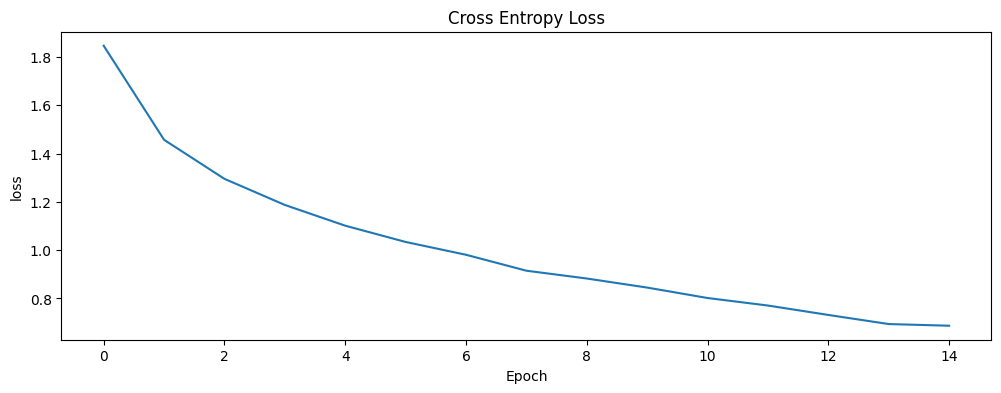

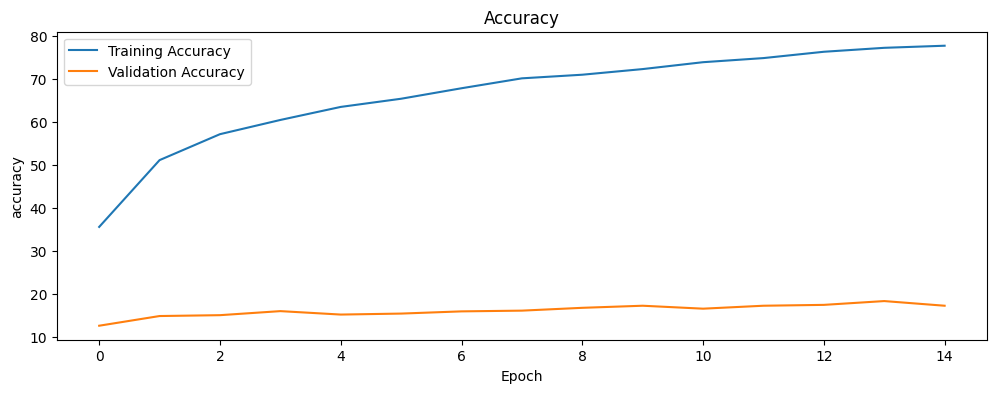

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train accuracy: 75.90
Test accuracy: 73.60
Confusion Matrix:
[[ 90   0   3   0   0   0   6   0   1   0]
 [  2 164   1  12   6   4   0   8   3   0]
 [  0   2  93   1   3   0   0   0   0   1]
 [  0   0   1 186   0   2   7   4   0   0]
 [  1   1   5   1  84   0   7   0   1   0]
 [  4   7   4  15   7 135  17   5   5   1]
 [  8   1   7   3   2   0 171   7   1   0]
 [  3  27   2   7   4  12   3 132   6   4]
 [  4   5   9   1   1   6  17   9  45   3]
 [ 10  14   4   6   3  17  11   9  22   4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.90      0.81       100
           1       0.74      0.82      0.78       200
           2       0.72      0.93      0.81       100
           3       0.80      0.93      0.86       200
           4       0.76      0.84      0.80       100
           5       0.77      0.68      0.72       200
           6       0.72      0.85      0.78       200
           7       0.76      0.66      0.71       20

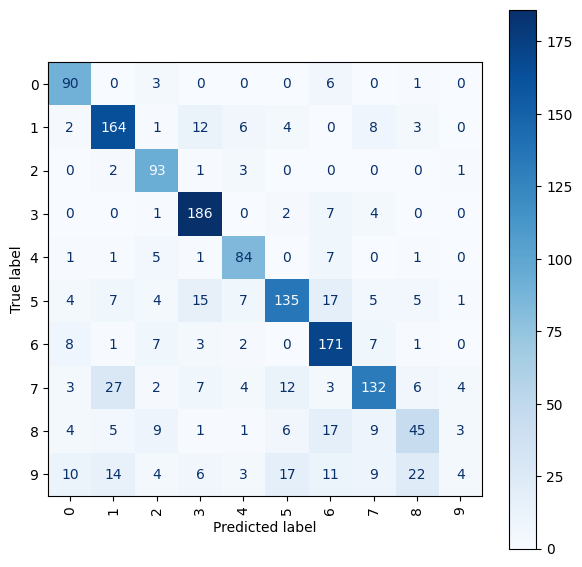

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


plt.figure(figsize=(12, 4))
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(accuracy, label="Training Accuracy")
plt.plot(valid_accuracy, label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


def evaluate_model(title, model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
            y_true.extend(targets.tolist())
            y_pred.extend(preds.tolist())

    print('{title} accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset), title=title))
    if title.lower() == "test":
        # Compute the confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Compute the precision, recall, and F1 score
        report = classification_report(y_true, y_pred)
        print('Confusion Matrix:')
        print(cm)
        print('Classification Report:')
        print(report)
        fig, ax = plt.subplots(figsize=(7, 7))
        ConfusionMatrixDisplay(cm).plot(ax=ax,cmap='Blues', xticks_rotation='vertical', values_format='d')
        plt.show()  


evaluate_model("Train", model, train_dataloader, device)
evaluate_model("Test", model, evaluation_dataloader, device)

## t-SNE

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


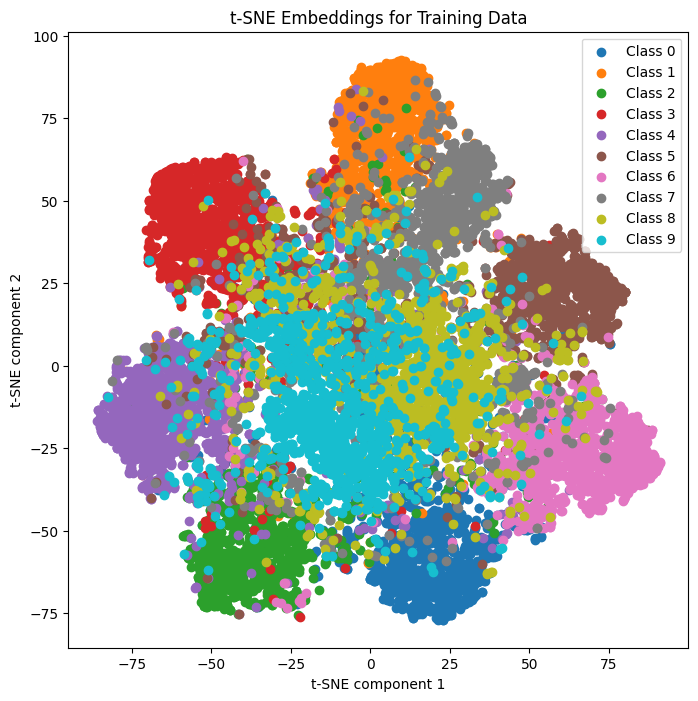

CPU times: user 2min 36s, sys: 4.15 s, total: 2min 40s
Wall time: 4min 18s


In [ ]:
%%time
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

def compute_tsne(model, dataloader):
    """
    Computes t-SNE embeddings for the given model and dataloader.
    """
    # Set model to evaluation mode
    model.eval()
        
    # Get the features from the last layer for all samples in the dataset
    features = []
    labels = []

    # Define a function to extract the features from the last layer
    # def get_features_hook(module, input, output):
    #     features.append(output.detach().cpu().numpy())

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            # model.fc.register_forward_hook(get_features_hook)
            outputs = model(inputs)
            features.append(outputs.detach().cpu().numpy())
            labels.append(targets.detach().cpu().numpy())
    
    features = np.concatenate(features)
    labels = np.concatenate(labels)

    # Compute t-SNE embeddings
    tsne = TSNE(n_components=2, perplexity=30, random_state=0)
    embeddings = tsne.fit_transform(features)

    return embeddings, labels


train_embeddings, train_labels = compute_tsne(model, train_dataloader)
# Plot t-SNE embeddings for the training datasets
import matplotlib.pyplot as plt

# Plot t-SNE embeddings
plt.figure(figsize=(8,8))
for i in range(num_classes):
    plt.scatter(train_embeddings[train_labels==i,0], train_embeddings[train_labels==i,1], label=f'Class {i}')
plt.legend()
plt.title('t-SNE Embeddings for Training Data')
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()

# Helper Funtion 

**not part of the experiment**

In [ ]:
# Load model
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)

<All keys matched successfully>

{'train_acc': [35.56103411513859, 51.12384506041222, 57.16728855721393, 60.481076759061835, 63.51945628997868, 65.4251066098081, 67.86824804548685, 70.17812722103767, 71.02212153518124, 72.33475479744136, 73.93834399431415, 74.89561122956646, 76.3681592039801, 77.28766879886282, 77.77629708599858], 'train_acc_valid': [12.542857142857141, 14.799999999999999, 15.0, 15.942857142857141, 15.142857142857144, 15.371428571428572, 15.885714285714286, 16.057142857142857, 16.714285714285715, 17.2, 16.514285714285716, 17.2, 17.4, 18.285714285714285, 17.2], 'train_loss': [1.8467846910582422, 1.457157085826402, 1.2954056101567202, 1.1873159137870204, 1.1013624224581444, 1.034018346368631, 0.9809225702336603, 0.9149222476268882, 0.8825889318736632, 0.8449868513449931, 0.8018107867317159, 0.7706148261581657, 0.7316820589082835, 0.6939305753977314, 0.6870465541699293], 'train_acc_step': [25.0, 21.875, 21.875, 28.125, 18.75, 53.125, 40.625, 43.75, 34.375, 37.5, 46.875, 50.0, 46.875, 50.0, 37.5, 50.0, 59

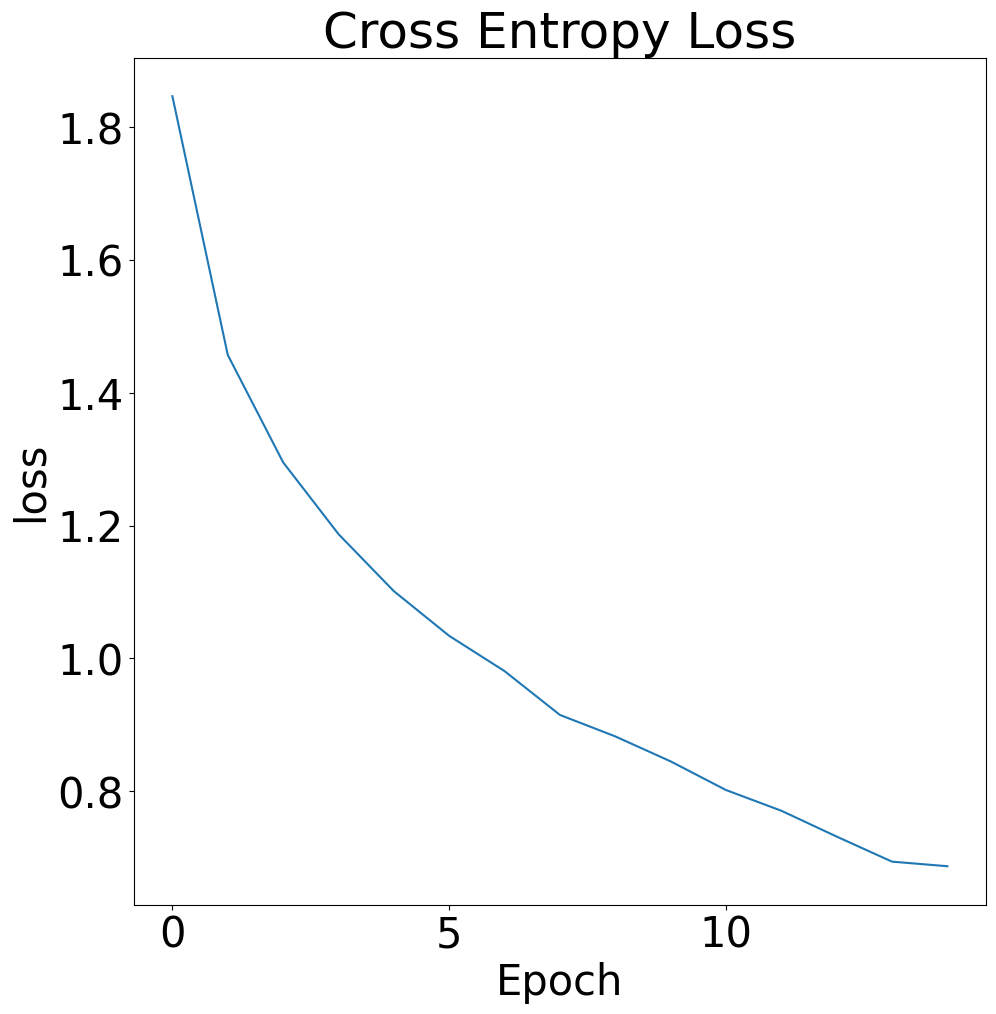

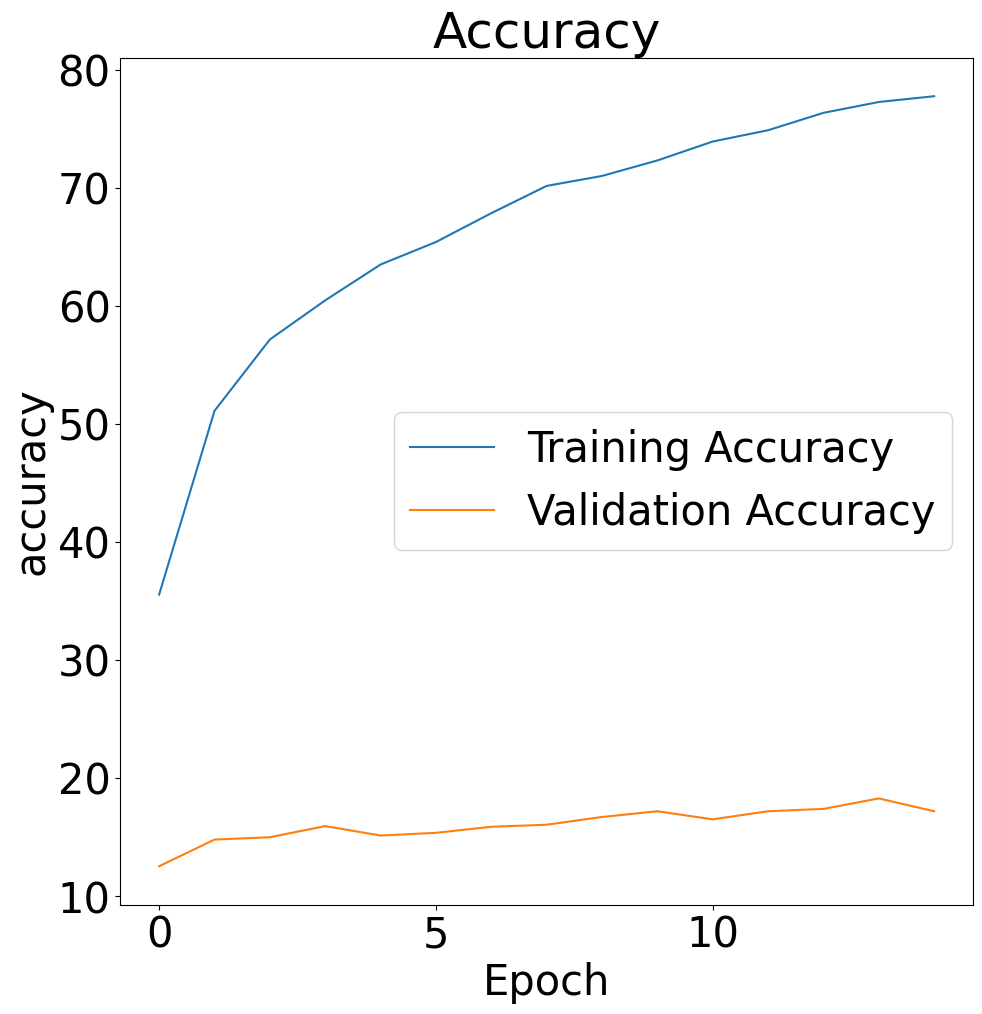

In [ ]:
# Load the experiment data from file and plot for report

with open(statistic_path, 'rb') as f:
    data = pickle.load(f)
    print(data)
    train_acc = data['train_acc']
    train_acc_valid = data['train_acc_valid']
    train_loss = data['train_loss']
    train_acc_step = data['train_acc_step']
    train_acc_valid_step = data['train_acc_valid_step']
    train_loss_step = data['train_loss_step']

plt.rcParams['font.size'] = '30'

plt.figure(figsize=(11, 11))
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

plt.figure(figsize=(11, 11))
plt.plot(train_acc, label="Training Accuracy")
plt.plot(train_acc_valid, label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


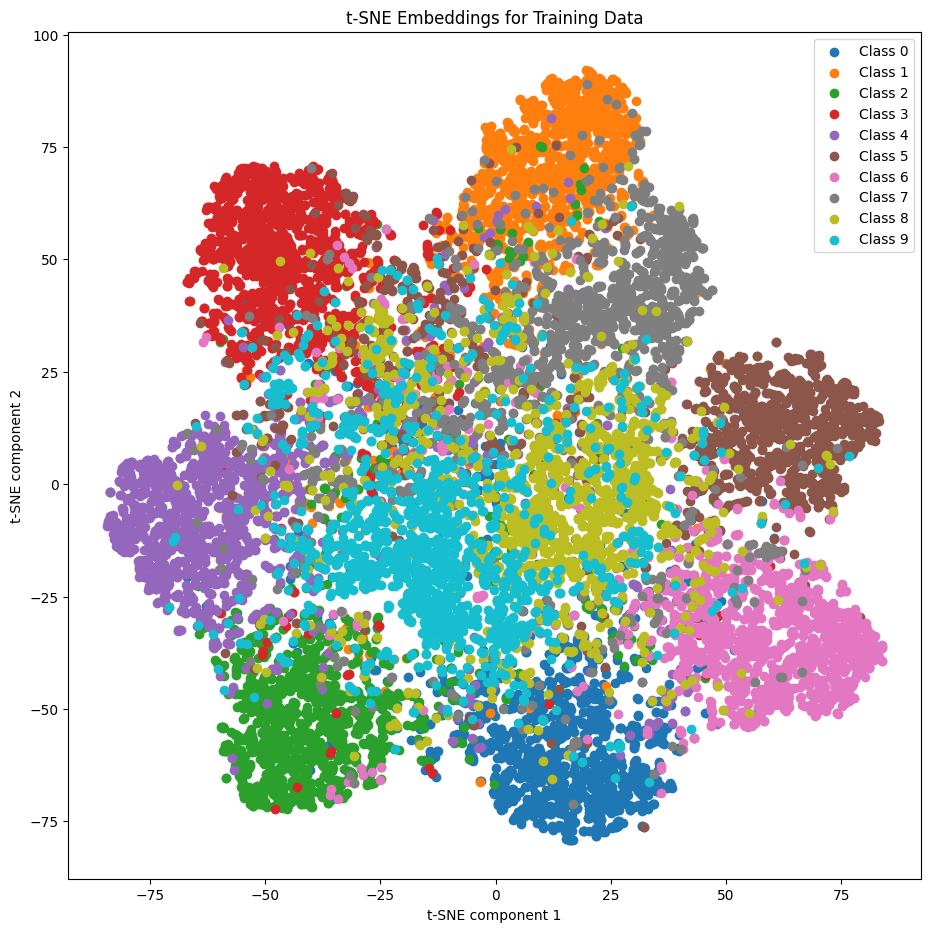

In [ ]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt


def compute_tsne(model, dataloader):
    """
    Computes t-SNE embeddings for the given model and dataloader.
    """
    # Set model to evaluation mode
    model.eval()
        
    # Get the features from the last layer for all samples in the dataset
    features = []
    labels = []

    # Define a function to extract the features from the last layer
    # def get_features_hook(module, input, output):
    #     features.append(output.detach().cpu().numpy())

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            # model.fc.register_forward_hook(get_features_hook)
            outputs = model(inputs)
            features.append(outputs.detach().cpu().numpy())
            labels.append(targets.detach().cpu().numpy())
    
    features = np.concatenate(features)
    labels = np.concatenate(labels)

    # Compute t-SNE embeddings
    tsne = TSNE(n_components=2, perplexity=30, random_state=0)
    embeddings = tsne.fit_transform(features)

    return embeddings, labels


train_embeddings, train_labels = compute_tsne(model, train_dataloader)
# Plot t-SNE embeddings for the training datasets
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = '10'

# Plot t-SNE embeddings
plt.figure(figsize=(11,11))
for i in range(num_classes):
    plt.scatter(train_embeddings[train_labels==i,0], train_embeddings[train_labels==i,1], label=f'Class {i}')
plt.legend()
plt.title('t-SNE Embeddings for Training Data')
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()